# Tech Challenge 4 - Análise dos valores dos barris de petróleo

Grupo:



*   Rafael Lopes Tanaka RM 356096

* Rafael Morais Vidal RM 354846

* Rodrigo Kenji Rossetti Inonhe RM 354906

* Lucas Morikawa Giovanini RM XXXXXX


## Desafio:

Um grande cliente do segmento pediu para que a consultoria
desenvolvesse um dashboard interativo para gerar insights relevantes para
tomada de decisão. Além disso, solicitaram que fosse desenvolvido um modelo
de Machine Learning para fazer o forecasting do preço do petróleo.

Tendo em vista este desafio, o nosso grupo de especialista se propos a montar uma análise cruzando uma série de informações e dados para buscar uma resposta satisfatória e utilizável para nosso cliente.

## Análise exploratória dos Dados e Feature Engineering Process

### Instalação das bibliotecas, declaração e coleta dos dados

Instalação das bibliotecas

In [ ]:
!pip3 install keras
!pip3 install tensorflow
!pip3 install prophet
!pip3 install yfinance
!pip install pmdarima
!pip3 install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 9.8 MB/s eta 0:00:00


Declaração das bibliotecas que vamos usar durante a análise

In [ ]:
import numpy as np
import pandas as pd
import requests
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split


from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

Processo de autenticação do google para uso do Big Query

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
import os
from google.cloud import bigquery
from google.colab import data_table

project= 'fiap-data-analytics'
location='US'
client = bigquery.Client(project = project, location = location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

Chamando as tabelas que iremos utilizar para a análise. Neste caso, nosso time optou por trazer informações dos valores de petróleo, valor do dolar, valores da gasolina, diesel, etanol e álcool, a bolsa do IBOVESPA e a bolsa de Nova York.

Todos estes indíces conterão o mesmo intervalo de tempo para que a análise gerada seja a mais acurada possível.

Para a extração dos dados das ações, usamos a biblioteca yfinance, assim conseguimos extrair os dados do IBPOVESPA e a NYSE.

Já para a extração ds dados dos valores do dolar e do preço do barril, extraímos diretamente do IPEA.

### Tratamento dos dados e limpeza das tabelas

#### Tratamento das tabelas de Valor de barril e Valor do Dolar

Criação do dataset do preço dos barris

In [ ]:
ds_barril = pd.read_csv("valor-petr-ipeadata[11-11-2024].csv", sep=";")

Apresentando a tabela do preço do petroleo

In [ ]:
ds_barril.head()

,Data,Preço - petróleo bruto - Brent (FOB) - US$ - Energy Information Administration (EIA) - EIA366_PBRENT366,Unnamed: 2
0,20/05/1987,"18,63",NaN
1,21/05/1987,"18,45",NaN
2,22/05/1987,"18,55",NaN
3,23/05/1987,NaN,NaN
4,24/05/1987,NaN,NaN


Agora vamos criar o dataset com os valores do dolar.

In [ ]:
ds_dolar = pd.read_csv("valor-dolar-ipeadata[16-11-2024].csv", sep=";")

In [ ]:
ds_dolar

,Data,"Taxa de câmbio - R$ / US$ - comercial - compra - média - R$ - Banco Central do Brasil, Sistema Gerenciador de Séries Temporais (Bacen Outras/SGS) - GM366_ERC366",Unnamed: 2
0,02/01/1985,"1,152E-09",NaN
1,03/01/1985,"1,152E-09",NaN
2,04/01/1985,"1,152E-09",NaN
3,05/01/1985,NaN,NaN
4,06/01/1985,NaN,NaN
...,...,...,...
14557,10/11/2024,NaN,NaN
14558,11/11/2024,"5,7974",NaN
14559,12/11/2024,"5,7688",NaN
14560,13/11/2024,"5,7707",NaN


Tirando a coluna vazia dos datasets de IPEA.

In [ ]:
ds_barril.drop(columns=['Unnamed: 2'], inplace=True)
ds_barril

,Data,Preço - petróleo bruto - Brent (FOB) - US$ - Energy Information Administration (EIA) - EIA366_PBRENT366
0,20/05/1987,"18,63"
1,21/05/1987,"18,45"
2,22/05/1987,"18,55"
3,23/05/1987,NaN
4,24/05/1987,NaN
...,...,...
13679,31/10/2024,"73,25"
13680,01/11/2024,"73,63"
13681,02/11/2024,NaN
13682,03/11/2024,NaN


In [ ]:
ds_dolar.drop(columns=['Unnamed: 2'], inplace=True)
ds_dolar

,Data,"Taxa de câmbio - R$ / US$ - comercial - compra - média - R$ - Banco Central do Brasil, Sistema Gerenciador de Séries Temporais (Bacen Outras/SGS) - GM366_ERC366"
0,02/01/1985,"1,152E-09"
1,03/01/1985,"1,152E-09"
2,04/01/1985,"1,152E-09"
3,05/01/1985,NaN
4,06/01/1985,NaN
...,...,...
14557,10/11/2024,NaN
14558,11/11/2024,"5,7974"
14559,12/11/2024,"5,7688"
14560,13/11/2024,"5,7707"


Renomeando a coluna de preços

In [ ]:
ds_barril.rename(columns={'Preço - petróleo bruto - Brent (FOB) - US$ - Energy Information Administration (EIA) - EIA366_PBRENT366': 'Preco(US)'}, inplace=True)
ds_barril

,Data,Preco(US)
0,20/05/1987,"18,63"
1,21/05/1987,"18,45"
2,22/05/1987,"18,55"
3,23/05/1987,NaN
4,24/05/1987,NaN
...,...,...
13679,31/10/2024,"73,25"
13680,01/11/2024,"73,63"
13681,02/11/2024,NaN
13682,03/11/2024,NaN


In [ ]:
ds_dolar.rename(columns={'Taxa de câmbio - R$ / US$ - comercial - compra - média - R$ - Banco Central do Brasil, Sistema Gerenciador de Séries Temporais (Bacen Outras/SGS) - GM366_ERC366': 'Valor do dolar(RS)'}, inplace=True)
ds_dolar

,Data,Valor do dolar(RS)
0,02/01/1985,"1,152E-09"
1,03/01/1985,"1,152E-09"
2,04/01/1985,"1,152E-09"
3,05/01/1985,NaN
4,06/01/1985,NaN
...,...,...
14557,10/11/2024,NaN
14558,11/11/2024,"5,7974"
14559,12/11/2024,"5,7688"
14560,13/11/2024,"5,7707"


In [ ]:
ds_barril.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13684 entries, 0 to 13683
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Data       13684 non-null  object
 1   Preco(US)  11292 non-null  object
dtypes: object(2)
memory usage: 213.9+ KB


In [ ]:
ds_dolar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14562 entries, 0 to 14561
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Data                14562 non-null  object
 1   Valor do dolar(RS)  9975 non-null   object
dtypes: object(2)
memory usage: 227.7+ KB


In [ ]:
ds_barril['Preco(US)'] = ds_barril["Preco(US)"].str.replace(',', '.')
ds_barril['Preco(US)'] = ds_barril['Preco(US)'].astype(float)
ds_barril

,Data,Preco(US)
0,20/05/1987,18.63
1,21/05/1987,18.45
2,22/05/1987,18.55
3,23/05/1987,NaN
4,24/05/1987,NaN
...,...,...
13679,31/10/2024,73.25
13680,01/11/2024,73.63
13681,02/11/2024,NaN
13682,03/11/2024,NaN


In [ ]:
ds_dolar['Valor do dolar(RS)'] = ds_dolar["Valor do dolar(RS)"].str.replace(',', '.')
ds_dolar['Valor do dolar(RS)'] = ds_dolar['Valor do dolar(RS)'].astype(float)
ds_dolar

,Data,Valor do dolar(RS)
0,02/01/1985,1.152000e-09
1,03/01/1985,1.152000e-09
2,04/01/1985,1.152000e-09
3,05/01/1985,NaN
4,06/01/1985,NaN
...,...,...
14557,10/11/2024,NaN
14558,11/11/2024,5.797400e+00
14559,12/11/2024,5.768800e+00
14560,13/11/2024,5.770700e+00


Remover valores menores que 1 do dataframe de valor de dolares

In [ ]:
ds_dolar = ds_dolar[ds_dolar['Valor do dolar(RS)'] > 1]
ds_dolar = ds_dolar.reset_index(drop=True)
ds_dolar

,Data,Valor do dolar(RS)
0,14/06/1996,1.0007
1,17/06/1996,1.0008
2,18/06/1996,1.0008
3,19/06/1996,1.0012
4,20/06/1996,1.0017
...,...,...
7118,08/11/2024,5.7642
7119,11/11/2024,5.7974
7120,12/11/2024,5.7688
7121,13/11/2024,5.7707


Dropando os três últimos valores para igualar ao dataframe dos barris

In [ ]:
ds_dolar.drop(ds_dolar.tail(3).index, inplace=True)
ds_dolar

,Data,Valor do dolar(RS)
0,14/06/1996,1.0007
1,17/06/1996,1.0008
2,18/06/1996,1.0008
3,19/06/1996,1.0012
4,20/06/1996,1.0017
...,...,...
7115,05/11/2024,5.7840
7116,06/11/2024,5.7642
7117,07/11/2024,5.6618
7118,08/11/2024,5.7642


In [ ]:
ds_barril.isna().sum()

,0
Data,0
Preco(US),2392


In [ ]:
ds_dolar.isna().sum()

,0
Data,0
Valor do dolar(RS),0


Tirando valores nulos que são os finais de semana

In [ ]:
ds_barril.dropna(inplace=True)
ds_barril.reset_index(drop=True, inplace=True)
ds_barril

,Data,Preco(US)
0,20/05/1987,18.63
1,21/05/1987,18.45
2,22/05/1987,18.55
3,25/05/1987,18.60
4,26/05/1987,18.63
...,...,...
11287,29/10/2024,71.09
11288,30/10/2024,73.21
11289,31/10/2024,73.25
11290,01/11/2024,73.63


Convertendo as datas para o formato de data

In [ ]:
ds_barril["Data"] = pd.to_datetime(ds_barril['Data'], yearfirst=True)

<ipython-input-21-7e73c56280a3>:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ds_barril["Data"] = pd.to_datetime(ds_barril['Data'], yearfirst=True)


In [ ]:
ds_dolar["Data"] = pd.to_datetime(ds_dolar['Data'], yearfirst=True)

<ipython-input-22-30d6e105b637>:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ds_dolar["Data"] = pd.to_datetime(ds_dolar['Data'], yearfirst=True)


In [ ]:
ds_barril.rename(columns={'Data': 'ds', 'Preco(US)': 'y'}, inplace=True)
#ds_barril.set_index('ds', inplace=True)
ds_barril

,ds,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
11287,2024-10-29,71.09
11288,2024-10-30,73.21
11289,2024-10-31,73.25
11290,2024-11-01,73.63


#### Tratamento das tabelas de Ações

In [ ]:
ds_ibov = yf.download('^BVSP', start='1993-01-01', end='2024-11-11')

[*********************100%***********************]  1 of 1 completed


In [ ]:
ds_nsye = yf.download('^NYA', start='1993-01-01', end='2024-11-11')

[*********************100%***********************]  1 of 1 completed


In [ ]:
ds_ibov.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^BVSP,^BVSP,^BVSP,^BVSP,^BVSP,^BVSP
Date,,,,,,
1993-04-27 00:00:00+00:00,24.500000,24.500000,25.400000,24.500000,24.799999,0
1993-04-28 00:00:00+00:00,24.299999,24.299999,24.600000,23.700001,24.500000,0
1993-04-29 00:00:00+00:00,23.700001,23.700001,24.799999,23.700001,24.299999,0
1993-04-30 00:00:00+00:00,24.100000,24.100000,24.200001,23.700001,23.700001,0
1993-05-03 00:00:00+00:00,24.100000,24.100000,24.400000,23.799999,24.100000,0


In [ ]:
ds_nsye.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^NYA,^NYA,^NYA,^NYA,^NYA,^NYA
Date,,,,,,
1993-01-04 00:00:00+00:00,2536.429932,2536.429932,2536.429932,2536.429932,2536.429932,0
1993-01-05 00:00:00+00:00,2529.770020,2529.770020,2529.770020,2529.770020,2529.770020,0
1993-01-06 00:00:00+00:00,2528.709961,2528.709961,2528.709961,2528.709961,2528.709961,0
1993-01-07 00:00:00+00:00,2508.719971,2508.719971,2508.719971,2508.719971,2508.719971,0
1993-01-08 00:00:00+00:00,2497.620117,2497.620117,2497.620117,2497.620117,2497.620117,0


Transformando os dataframes para usarmos apenas o campo de Close, e outras conversões para padronização dos dados.

In [ ]:
ds_ibov = ds_ibov[['Close']]
ds_nsye = ds_nsye[['Close']]

In [ ]:
ds_nsye.reset_index(inplace=True)
ds_ibov.reset_index(inplace=True)

In [ ]:
ds_ibov.rename(columns={'Date': 'Data'}, inplace=True)
ds_nsye.rename(columns={'Date': 'Data'}, inplace=True)

In [ ]:
ds_ibov.head()

Price,Data,Close
Ticker,,^BVSP
0,1993-04-27 00:00:00+00:00,24.500000
1,1993-04-28 00:00:00+00:00,24.299999
2,1993-04-29 00:00:00+00:00,23.700001
3,1993-04-30 00:00:00+00:00,24.100000
4,1993-05-03 00:00:00+00:00,24.100000


In [ ]:
ds_nsye.head()

Price,Data,Close
Ticker,,^NYA
0,1993-01-04 00:00:00+00:00,2536.429932
1,1993-01-05 00:00:00+00:00,2529.770020
2,1993-01-06 00:00:00+00:00,2528.709961
3,1993-01-07 00:00:00+00:00,2508.719971
4,1993-01-08 00:00:00+00:00,2497.620117


### Análise exploratória dos dados

Plotando os gráficos

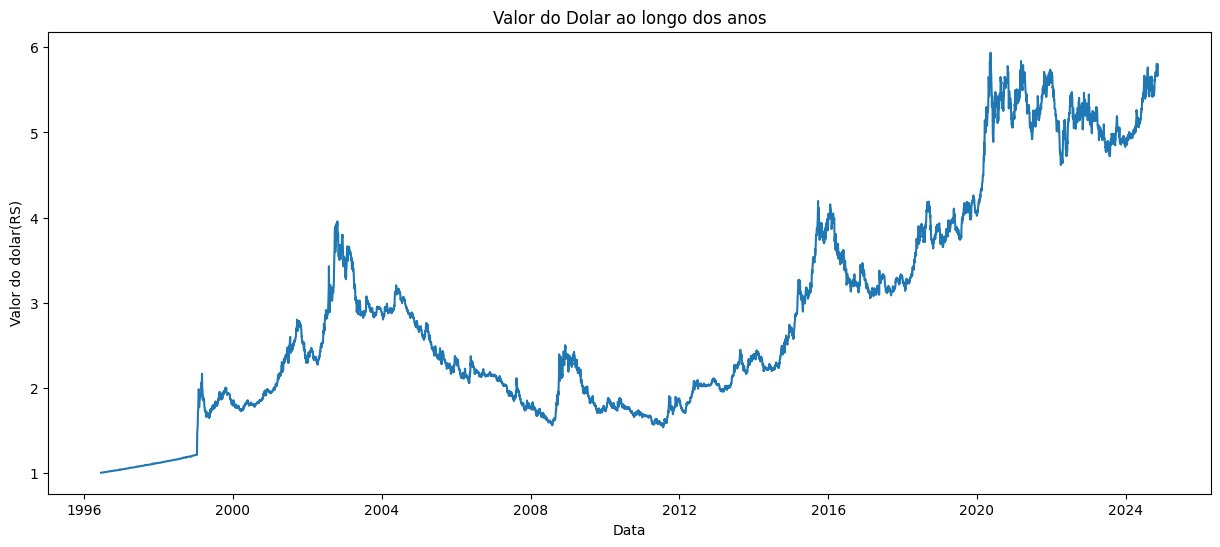

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=ds_dolar, x='Data', y='Valor do dolar(RS)')
plt.title('Valor do Dolar ao longo dos anos')
plt.show()

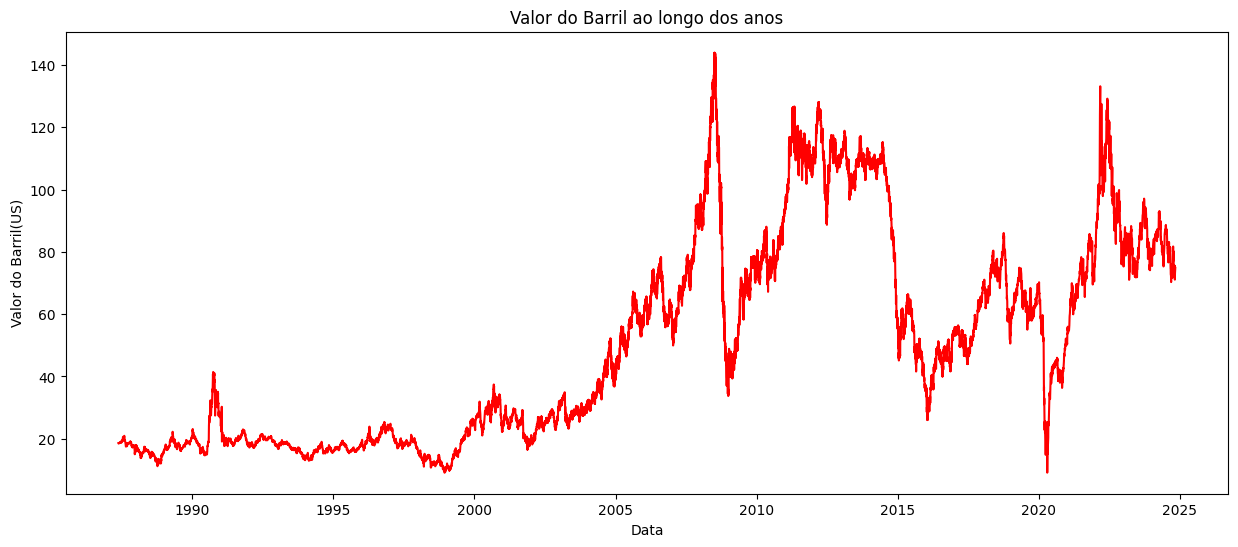

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=ds_barril, x='ds', y='y', color='red')
plt.xlabel('Data')
plt.ylabel('Valor do Barril(US)')
plt.title('Valor do Barril ao longo dos anos')
plt.show()

Sobreposição dos gráficos de valores do barril com o valor do dolar usando a normalização dos dados


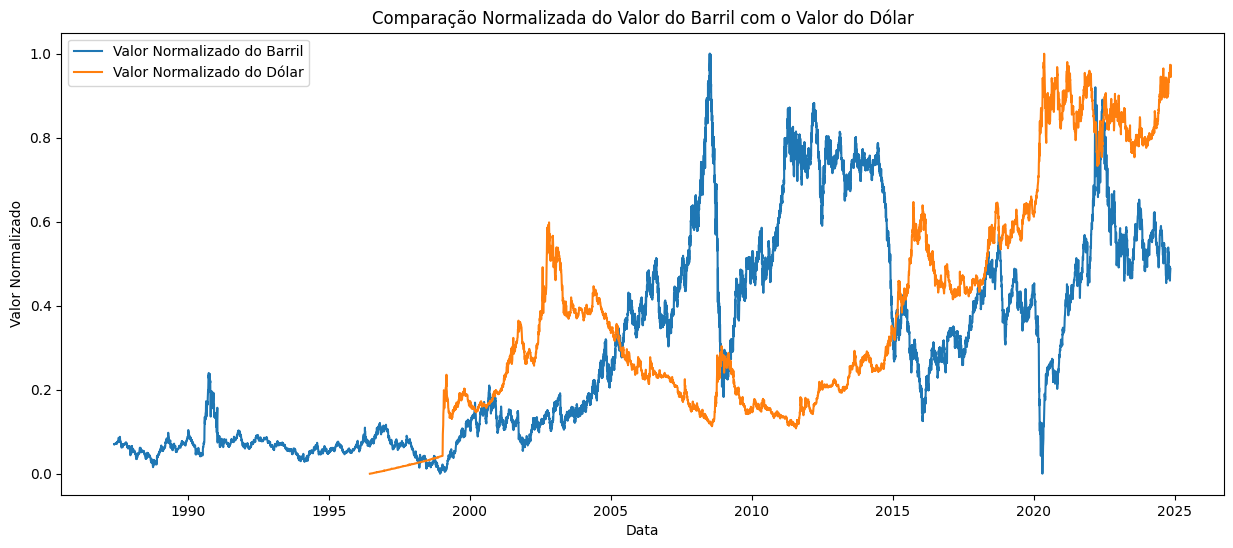

In [ ]:
ds_barril['Valor Normalizado'] = (ds_barril['y'] - ds_barril['y'].min()) / (ds_barril['y'].max() - ds_barril['y'].min())
ds_dolar['Valor Normalizado'] = (ds_dolar['Valor do dolar(RS)'] - ds_dolar['Valor do dolar(RS)'].min()) / (ds_dolar['Valor do dolar(RS)'].max() - ds_dolar['Valor do dolar(RS)'].min())

# Plotando os valores normalizados
plt.figure(figsize=(15, 6))
plt.plot(ds_barril['ds'], ds_barril['Valor Normalizado'], label='Valor Normalizado do Barril')
plt.plot(ds_dolar['Data'], ds_dolar['Valor Normalizado'], label='Valor Normalizado do Dólar')
plt.title('Comparação Normalizada do Valor do Barril com o Valor do Dólar')
plt.xlabel('Data')
plt.ylabel('Valor Normalizado')
plt.legend()
plt.show()

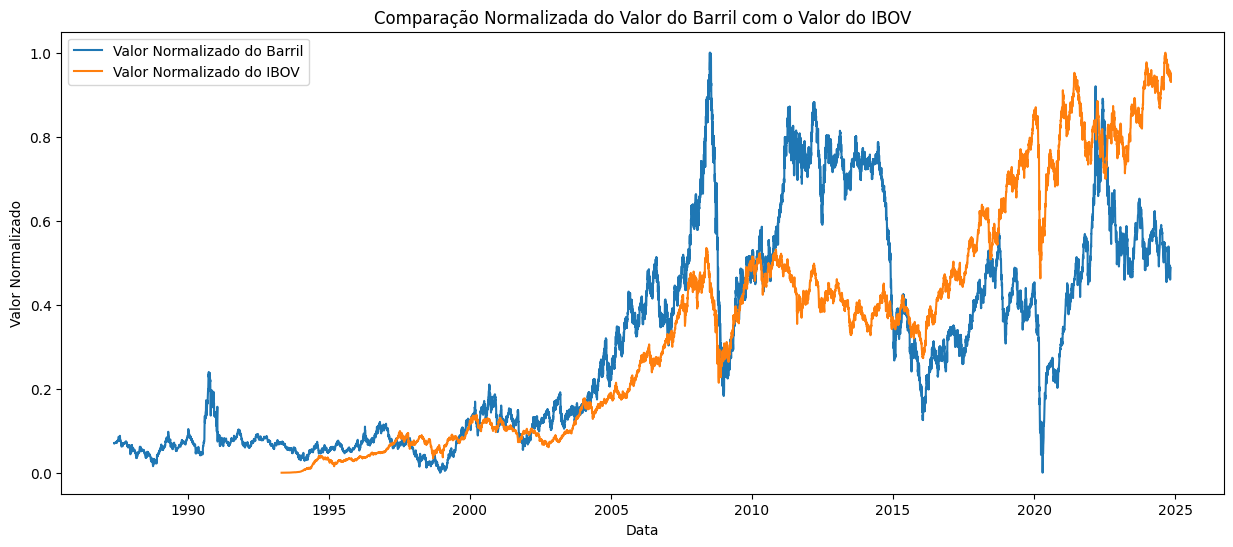

In [ ]:
ds_ibov['Valor Normalizado'] = (ds_ibov['Close'] - ds_ibov['Close'].min()) / (ds_ibov['Close'].max() - ds_ibov['Close'].min())

# Plotando os valores normalizados
plt.figure(figsize=(15, 6))
plt.plot(ds_barril['ds'], ds_barril['Valor Normalizado'], label='Valor Normalizado do Barril')
plt.plot(ds_ibov['Data'], ds_ibov['Valor Normalizado'], label='Valor Normalizado do IBOV')
plt.title('Comparação Normalizada do Valor do Barril com o Valor do IBOV')
plt.xlabel('Data')
plt.ylabel('Valor Normalizado')
plt.legend()
plt.show()

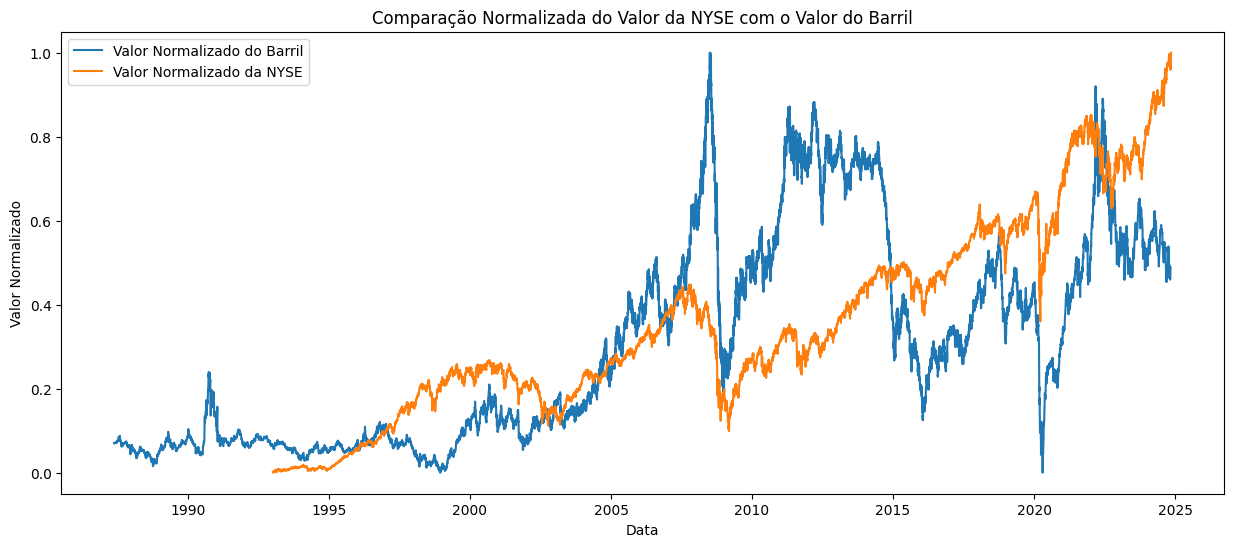

In [ ]:
ds_nsye['Valor Normalizado'] = (ds_nsye['Close'] - ds_nsye['Close'].min()) / (ds_nsye['Close'].max() - ds_nsye['Close'].min())

# Plotando os valores normalizados
plt.figure(figsize=(15, 6))
plt.plot(ds_barril['ds'], ds_barril['Valor Normalizado'], label='Valor Normalizado do Barril')
plt.plot(ds_nsye['Data'], ds_nsye['Valor Normalizado'], label='Valor Normalizado da NYSE')
plt.title('Comparação Normalizada do Valor da NYSE com o Valor do Barril')
plt.xlabel('Data')
plt.ylabel('Valor Normalizado')
plt.legend()
plt.show()

Alguns insights:



*   Base de dados bem pequena, com apenas duas colunas
*   Podemos tentar separar a análise por ano
*   Podemos ver se vale a pena trazer dados externos desta vez



## Análise usando os modelos para Time Series

### Prophet

In [ ]:
ds_barril.tail()


,ds,y
11287,2024-10-29,71.09
11288,2024-10-30,73.21
11289,2024-10-31,73.25
11290,2024-11-01,73.63
11291,2024-11-04,74.89


In [ ]:
ds_barril.shape

(11292, 2)

In [ ]:
train, test = ds_barril.loc[0:9033], ds_barril.loc[9034:]

In [ ]:
# Aplicando o modelo Prophet
model_prophet = Prophet()
model_prophet.fit(ds_barril)
future = model_prophet.make_future_dataframe(periods=90, freq='B') # Vamos usar um periodo de 90 dias para frente, com uma frequencia B de dias uteis
forecast = model_prophet.predict(future) # Criando as previsoes.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphdc69k6f/_o9w6vyi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphdc69k6f/7uhkiyq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70238', 'data', 'file=/tmp/tmphdc69k6f/_o9w6vyi.json', 'init=/tmp/tmphdc69k6f/7uhkiyq_.json', 'output', 'file=/tmp/tmphdc69k6f/prophet_models0mcggd7/prophet_model-20241120191401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:14:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:14:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#Metricas do Prophet
prophet_forecast = forecast.loc[test.index]['yhat'] # Alinha as previsões do Prophet (yhat) com as datas do conjunto de teste.
prophet_mae = mean_absolute_error(test['y'], prophet_forecast)
prophet_rmse = mean_squared_error(test['y'], prophet_forecast, squared=False)
prophet_mape = mean_absolute_percentage_error(test['y'], prophet_forecast)


print(f"Prophet MAE: {prophet_mae}, RMSE: {prophet_rmse}, MAPE: {prophet_mape}")

Prophet MAE: 10.740724735948021, RMSE: 15.227675096929067, MAPE: 0.1960193464778527


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Prophet: 10.74
MAE (Mean Absolute Error):
Média dos valores absolutos dos erros. Indica o quão perto as previsões estão dos valores reais, em média.



Prophet: 15.22
RMSE (Root Mean Squared Error):
Raiz quadrada da média dos erros quadráticos. Penaliza erros maiores mais do que MAE.


Prophet: 0.19
MAPE (Mean Absolute Percentage Error):
Média dos erros absolutos percentuais. Indica o erro médio em termos percentuais.



Interpretação dos Resultados

Os resultados indicam que o modelo Prophet tem um desempenho melhor do que o modelo ARIMA para este conjunto de dados, pois todas as métricas de erro (MAE, RMSE, MAPE) são menores para o Prophet. Isso significa que, em média, as previsões do Prophet estão mais próximas dos valores reais do que as previsões do ARIMA.

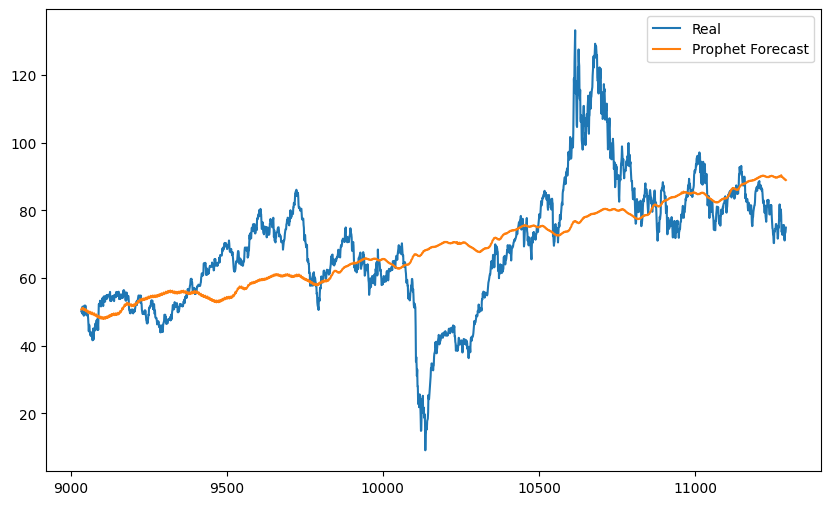

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['y'], label='Real')
plt.plot(test.index, prophet_forecast, label='Prophet Forecast')
plt.legend()
plt.show()

              ds       yhat  yhat_lower  yhat_upper
11377 2025-03-04  91.404819   76.977650  104.886387
11378 2025-03-05  91.377592   77.496497  105.949305
11379 2025-03-06  91.478961   78.577175  105.455410
11380 2025-03-07  91.479531   77.289247  105.018092
11381 2025-03-10  91.429804   76.561399  106.128169


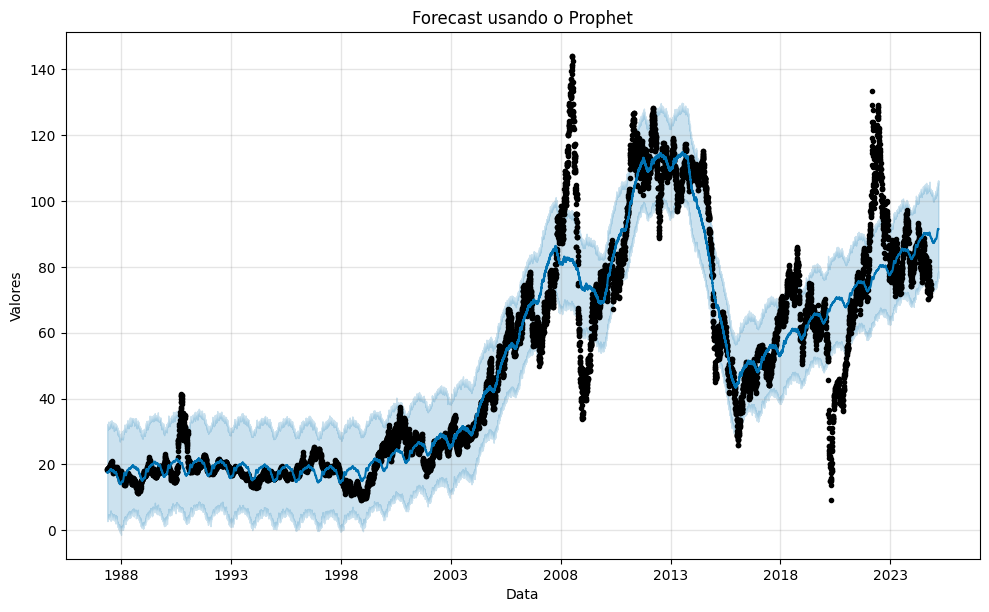

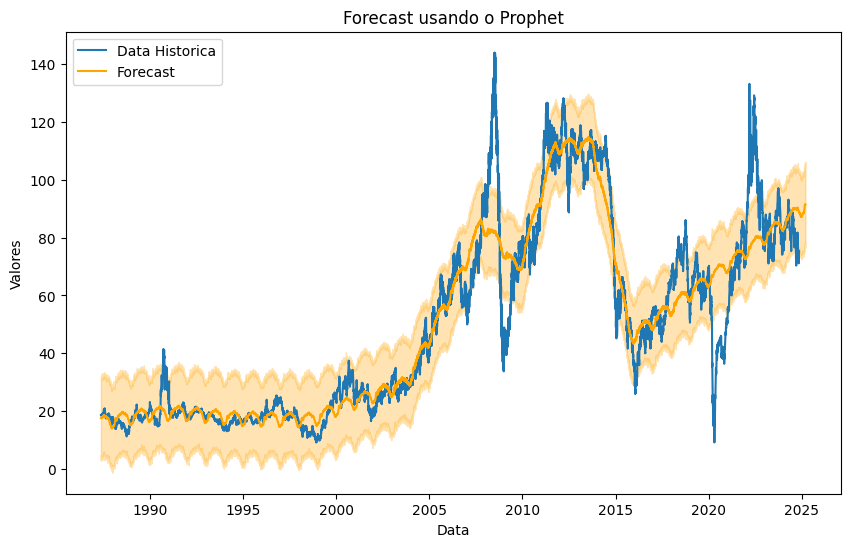

In [ ]:
# Verifique os valores das previsões
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plotando usando Prophet's built-in plot method
fig1 = model_prophet.plot(forecast)
plt.title('Forecast usando o Prophet')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.show()

# Plotando com Matplotlib para mais ajustes
plt.figure(figsize=(10, 6))
plt.plot(ds_barril['ds'], ds_barril['y'], label='Data Historica')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.3)
plt.title('Forecast usando o Prophet')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()

### LSTM

In [ ]:
#Criando um novo dataframe usando apenas a coluna de fechamento
data = ds_barril.filter(['y'])

#Convertendo o dataframe para um array numpy
dataset = data.values

training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len


10728

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.07067112],
       [0.0693363 ],
       [0.07007786],
       ...,
       [0.47571376],
       [0.4785317 ],
       [0.48787542]])

In [ ]:
train_data = scaled_data[0:int(training_data_len), :]

#Dividindo os dados em conjuntos de dados x_train e y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

#Convertendo x_train e y_train em matrizes numpy
x_train, y_train = np.array(x_train), np.array(y_train)

#Remodelando os dados
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# x_train.shape

[array([0.07067112, 0.0693363 , 0.07007786, 0.07044865, 0.07067112,
       0.07044865, 0.07044865, 0.07030033, 0.07081943, 0.0710419 ,
       0.07156099, 0.07178346, 0.07081943, 0.07156099, 0.07178346,
       0.07178346, 0.0710419 , 0.07178346, 0.07267334, 0.07363737,
       0.07378569, 0.07378569, 0.07415647, 0.07267334, 0.07156099,
       0.07119021, 0.07400816, 0.07452725, 0.07400816, 0.07326659,
       0.07526882, 0.07586207, 0.07697442, 0.07712273, 0.07697442,
       0.07845755, 0.07882833, 0.07956989, 0.07994067, 0.08290693,
       0.08379681, 0.08550241, 0.08490916, 0.08342603, 0.08327772,
       0.0819429 , 0.07771598, 0.0756396 , 0.07919911, 0.08068224,
       0.08231368, 0.08105302, 0.08787542, 0.08565072, 0.07934742,
       0.07897664, 0.07823508, 0.07660363, 0.07675195, 0.07712273])]
[0.07638116425658138]

[array([0.07067112, 0.0693363 , 0.07007786, 0.07044865, 0.07067112,
       0.07044865, 0.07044865, 0.07030033, 0.07081943, 0.0710419 ,
       0.07156099, 0.07178346, 0.07

In [ ]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compilando o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

#Treinando o modelo
model.fit(x_train, y_train, batch_size=1, epochs=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10668/10668 ━━━━━━━━━━━━━━━━━━━━ 605s 56ms/step - loss: 0.0011


In [ ]:
#Criar o conjunto de dados de teste
#Criar o conjunto de dados de teste. Criar uma nova matriz contendo valores escalonados do índice 1543 a 2002
test_data = scaled_data[training_data_len - 60: , :]

#Criar os conjuntos de dados x_test e y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

#Converter os dados em um array numpy
x_test = np.array(x_test)

#Remodelar os dados
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

#Obter os valores de preços previstos dos modelos
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

#Obter a raiz do erro quadrático médio (RMSE)
mape = mean_absolute_percentage_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
MAPE: 0.02%
MAE: 1.43
RMSE: 1.88


<ipython-input-100-6a6884dbd998>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



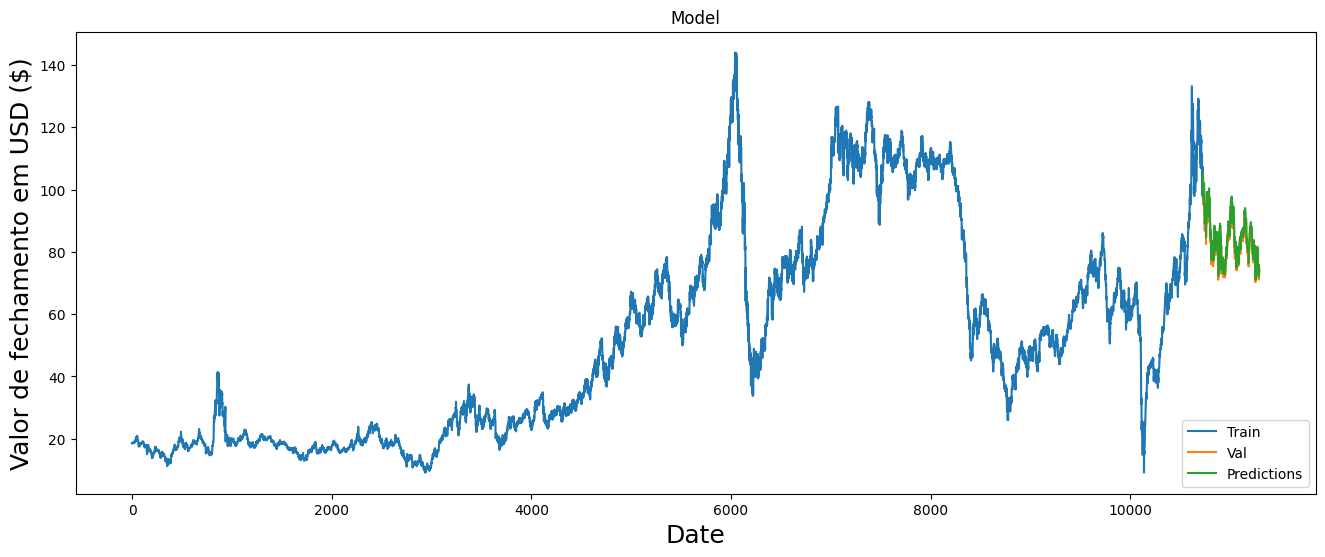

In [ ]:
# Plot
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#Visualize
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Valor de fechamento em USD ($)', fontsize=18)
plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Criar o gráfico
fig = go.Figure()

# Adicionar a linha de treino
fig.add_trace(go.Scatter(x=train.index, y=train['y'], mode='lines', name='Train'))

# Adicionar a linha de validação
fig.add_trace(go.Scatter(x=valid.index, y=valid['y'], mode='lines', name='Val'))

# Adicionar a linha de previsões
fig.add_trace(go.Scatter(x=valid.index, y=valid['Predictions'], mode='lines', name='Predictions'))

# Atualizar o layout do gráfico
fig.update_layout(
    title='Model',
    xaxis_title='Date',
    yaxis_title='Close Price USD ($)',
    legend=dict(x=1, y=0, traceorder='normal', orientation='h')
)

# Exibir o gráfico
fig.show()

### RNN Regressor


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11292 entries, 0 to 11291
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      11292 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 88.3 KB


In [ ]:
# Preparação dos dados
y = ds_barril['y'].values

# Definindo uma janela de tempo (número de steps passados usados como entrada)
window_size = 10

# Criando os conjuntos de entrada (X) e saída (y) com base na janela de tempo
X, y_rnn = [], []
for i in range(len(y) - window_size):
    X.append(y[i:i+window_size])
    y_rnn.append(y[i+window_size])

X = np.array(X)
y_rnn = np.array(y_rnn)

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_rnn, test_size=0.2, shuffle=False)

# Ajustando os dados para a entrada da RNN (adicionando uma dimensão)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Construção do modelo RNN
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)  # Saída de um único valor (regressão)
])

# Compilando o modelo
model.compile(optimizer='adam', loss='mse')

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=1, batch_size=1, validation_split=0.2, verbose=1)

# Fazendo previsões
y_pred = model.predict(X_test)

7220/7220 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 27.6809 - val_loss: 4.2633
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
# Calculando as métricas de erro
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Exibindo as métricas
print(f"MAPE: {mape:.2f}%")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.02%
MAE: 1.46
RMSE: 2.05


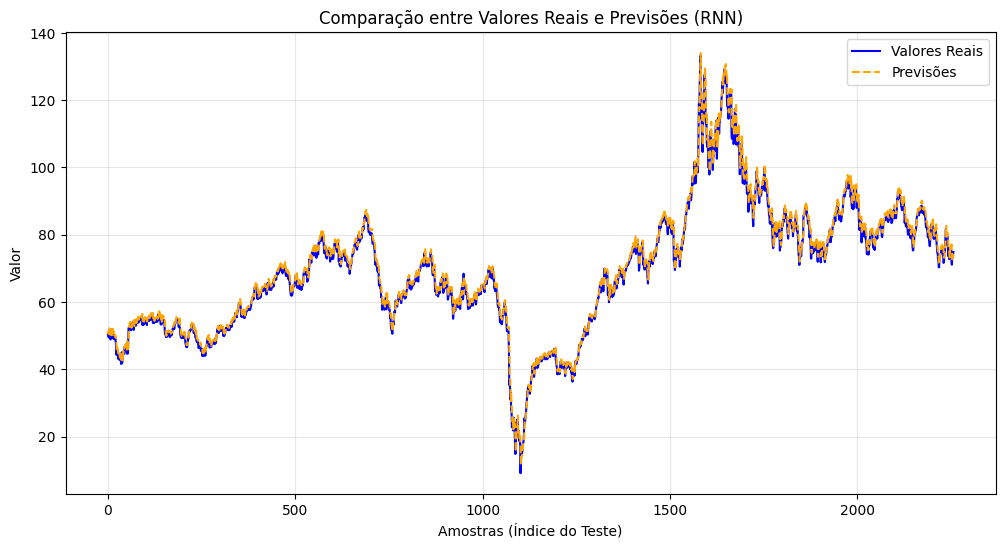

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Valores Reais', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Previsões', color='orange', linestyle='dashed')
plt.title('Comparação entre Valores Reais e Previsões (RNN)')
plt.xlabel('Amostras (Índice do Teste)')
plt.ylabel('Valor')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Benchmark dos modelos

In [ ]:
val_LSTM = {'RMSE': 1.88, 'MAPE': 0.02, 'MAE': 1.43}
val_RNN = {'RMSE': 2.05, 'MAPE': 0.02, 'MAE': 1.46 }
val_Prophet = {'RMSE': 15.22, 'MAPE': 19, 'MAE': 10.74}

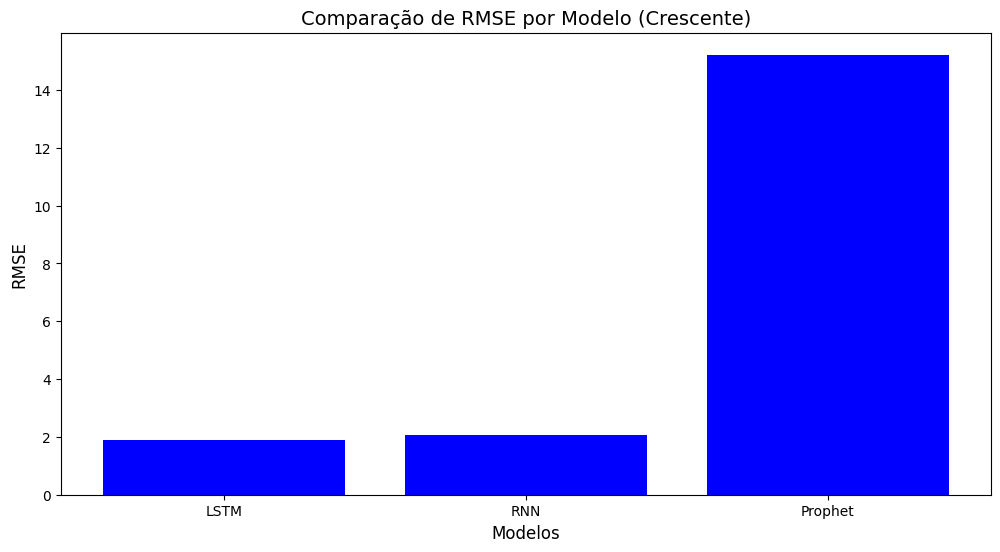

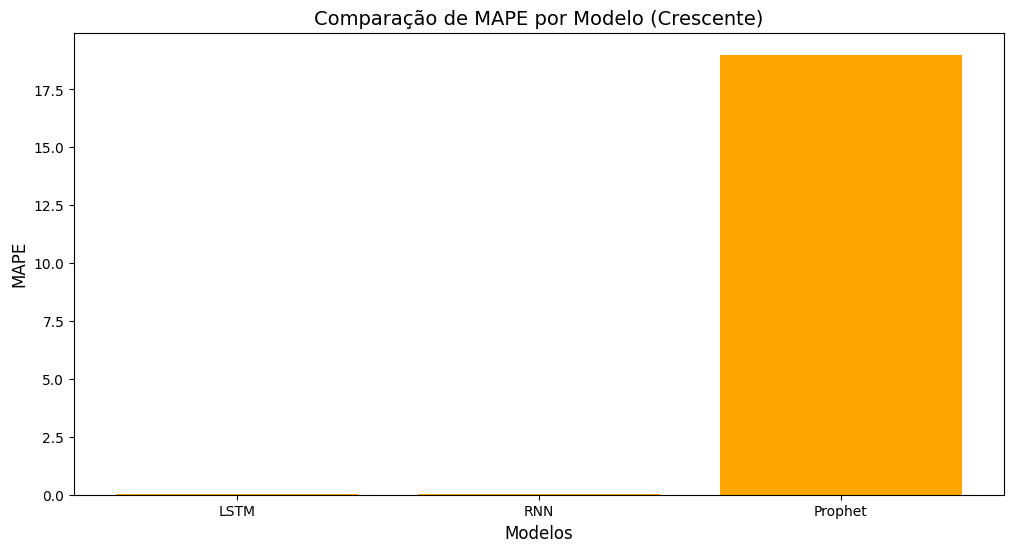

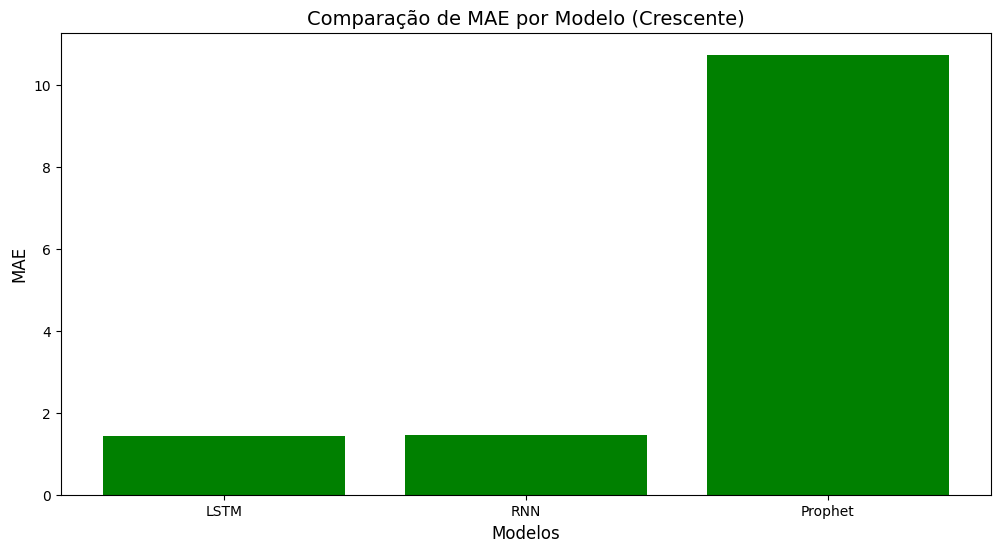

In [ ]:
data = {
    'Modelos': ['LSTM', 'RNN', 'Prophet'],
    'RMSE': [val_LSTM['RMSE'], val_RNN['RMSE'], val_Prophet['RMSE']],
    'MAPE': [val_LSTM['MAPE'], val_RNN['MAPE'], val_Prophet['MAPE']],
    'MAE': [val_LSTM['MAE'], val_RNN['MAE'], val_Prophet['MAE']]
}

df = pd.DataFrame(data)

# Ordenando e criando gráficos
# Gráfico para RMSE
df_rmse = df.sort_values(by='RMSE')
plt.figure(figsize=(12, 6))
plt.bar(df_rmse['Modelos'], df_rmse['RMSE'], color='blue')
plt.title('Comparação de RMSE por Modelo (Crescente)', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('Modelos', fontsize=12)
plt.show()

# Gráfico para MAPE
df_mape = df.sort_values(by='MAPE')
plt.figure(figsize=(12, 6))
plt.bar(df_mape['Modelos'], df_mape['MAPE'], color='orange')
plt.title('Comparação de MAPE por Modelo (Crescente)', fontsize=14)
plt.ylabel('MAPE', fontsize=12)
plt.xlabel('Modelos', fontsize=12)
plt.show()

# Gráfico para MAE
df_mae = df.sort_values(by='MAE')
plt.figure(figsize=(12, 6))
plt.bar(df_mae['Modelos'], df_mae['MAE'], color='green')
plt.title('Comparação de MAE por Modelo (Crescente)', fontsize=14)
plt.ylabel('MAE', fontsize=12)
plt.xlabel('Modelos', fontsize=12)
plt.show()

Em resumo:

Os modelos recomendados para realizar a previsão dos valores dos barris de petróleo são o RNN Regressor e o LSTM por se tratarem de modelos que usam o método de Deep Learning e apresentarem resultados mais acurados ao se comparar com modelos tradicionais de Machine Learning.

Como podemos observar, os indícies de RMSE, MAE e MAPE são bem inferiores comparados ao modelo do Prophet. Isto levando em consideração que o treinamento dos modelos de LSTM e RNN foi feito usando apenas 1 epoch e 1 batch size, demonstrando que o treinamento foi simples e mesmo assim ainda teve maior acurácia.
